#Package Imports

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
st_scaler = StandardScaler()
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 1.4 MB 9.1 MB/s 
     |████████████████████████████████| 9.8 MB 37.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


#Data prep

In [ ]:
#Reading the data
power = pd.read_csv("https://raw.githubusercontent.com/zeitgeist-hash/GRAD-C24-Machine-Learning/main/Tetuan%20City%20power%20consumption.csv")

##Transforming data

In [ ]:
#Formatting the columns
power["DT"] = pd.to_datetime(power["DateTime"])
power.columns = power.columns.str.replace(' ', '')
power=power.rename(columns={"generaldiffuseflows": "GeneralDiffuseFlows", "diffuseflows": "DiffuseFlows", "Zone1PowerConsumption":"Zone1", "Zone2PowerConsumption":"Zone2","Zone3PowerConsumption":"Zone3"})

#Aggregate consumption
power["MeanConsumption"] = power[['Zone1', 'Zone2', 'Zone3']].mean(axis=1)

#Inserting dummy variables for temporal data -- some of these may be redundant
power["Month"]=pd.DatetimeIndex(power['DT']).month
power["Day"]=pd.DatetimeIndex(power['DT']).day # returns day of month from 1 to 31
power["DayOfWeek"]=pd.DatetimeIndex(power['DT']).weekday # day of week from 0 to 6
power["Weekday"] = (pd.DatetimeIndex(power['DT']).weekday < 5).astype(int) # 1-0 dummy for weekday or not
power["Hour"]=pd.DatetimeIndex(power['DT']).hour
power["Week"]=pd.DatetimeIndex(power['DT']).week

#Seasons: 
seasons = [1,1,2,2,2,3,3,3,4,4,4,1]
month_to_season = dict(zip(range(1,13), seasons))
power["Season"]=power.DT.dt.month.map(month_to_season) 

##Hourly aggregate

In [ ]:
#Creating a new dataframe with hourly aggregates
power_hour = power.groupby(["Month", "Day", "Hour"], as_index=False).mean().copy()
power_hour["Year"] = 2017
power_hour["DT"] = pd.to_datetime(power_hour[["Year", "Month", "Day", "Hour"]])
power_hour = power_hour.set_index('DT')

In [ ]:
power_hour.head(10)
power_hour.shape

(8736, 17)

#Selecting covariates and outcome

In [ ]:
X = power_hour.loc[:, ["Temperature", "Humidity", "WindSpeed", "GeneralDiffuseFlows", 
                      "DiffuseFlows", "Season", "Month", "Hour", "DayOfWeek"]]
print(X, "\n")

y = power_hour.loc[:, ["MeanConsumption"]]
print("\n", y)

                     Temperature   Humidity  WindSpeed  GeneralDiffuseFlows  \
DT                                                                            
2017-01-01 00:00:00     6.196833  75.066667   0.081833             0.063500   
2017-01-01 01:00:00     5.548833  77.583333   0.082000             0.056833   
2017-01-01 02:00:00     5.054333  78.933333   0.082333             0.063000   
2017-01-01 03:00:00     5.004333  77.083333   0.082833             0.059833   
2017-01-01 04:00:00     5.097667  74.050000   0.082333             0.058000   
...                          ...        ...        ...                  ...   
2017-12-30 19:00:00     9.453333  62.406667   0.074667             0.052000   
2017-12-30 20:00:00     9.041667  63.990000   0.080333             0.052667   
2017-12-30 21:00:00     8.011667  69.675000   0.081500             0.073167   
2017-12-30 22:00:00     7.598333  70.315000   0.081833             0.058667   
2017-12-30 23:00:00     6.877500  72.900000   0.0815

#Train/test splitting

In [ ]:
#Function that uses the dataset and the desired test ratio to calculate and output the training, testing and validation sets.
def split_train_test(data, test_ratio):
  test_size = int(len(data) * test_ratio)
  df_train = data[:-test_size]
  df_test = data[-test_size:]
  df_valid = df_train[-test_size:]
  df_train = df_train[:-test_size]
  return df_train, df_test, df_valid

In [ ]:
#Splitting the X and y data with the splitting function
train_x, test_x, valid_x = split_train_test(X, 0.20)
train_y, test_y, valid_y = split_train_test(y, 0.20)

In [ ]:
#Checking the dimensions of the training, testing and validation sets.
print("X sets dimensions.", "Training set: ", train_x.shape, ". Test set: ", test_x.shape, " . Validation set: ", valid_x.shape)
print("y sets dimensions.", "Training set: ", train_y.shape, ". Test set: ", test_y.shape, " . Validation set: ", valid_y.shape)

X sets dimensions. Training set:  (5242, 9) . Test set:  (1747, 9)  . Validation set:  (1747, 9)
y sets dimensions. Training set:  (5242, 1) . Test set:  (1747, 1)  . Validation set:  (1747, 1)


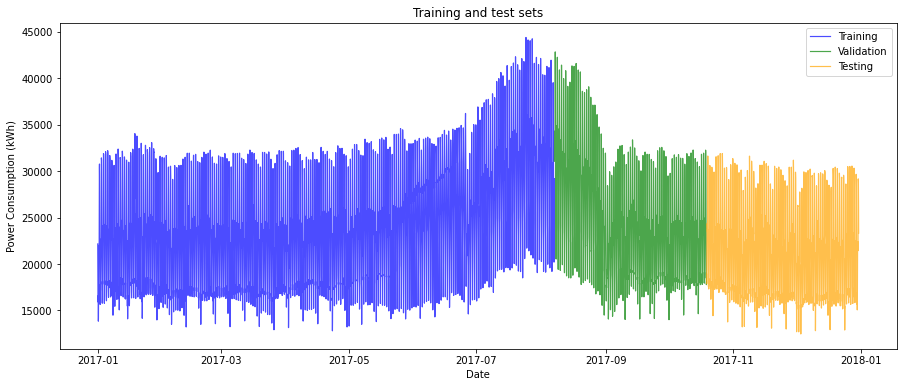

In [ ]:
#Plotting the training, testing and validation outputs. 
plt.figure(figsize=(15,6))
plt.plot(train_x.index, train_y, label = "Training", color="blue", alpha=0.7, lw=1.2)
plt.plot(valid_x.index, valid_y, label = "Validation", color="green", alpha=0.7, lw=1.2)
plt.plot(test_x.index, test_y, label = "Testing", color="orange", alpha=0.7, lw=1.2)
plt.xlabel('Date')
plt.ylabel('Power Consumption (kWh)')
plt.title("Training and test sets")
plt.legend()
plt.show()

## Checking the Stationarity of the data with the Adfuller statistical test

In [ ]:
#Stationarity test for our timeseries
from statsmodels.tsa.stattools import adfuller

#Calculates statistics for target variable
print(adfuller(power_hour["MeanConsumption"]))

#Calculates statistics for the summer
target=power_hour["MeanConsumption"].loc["2017-07":"2017-09"]
print(adfuller(target))

(-2.573768830541299, 0.09854080867954679, 37, 8698, {'1%': -3.4311020385052733, '5%': -2.8618723508056814, '10%': -2.566946905374546}, 128372.67391899043)
(-1.3904104524779466, 0.586864735826221, 27, 2180, {'1%': -3.4333532186762805, '5%': -2.862866720471125, '10%': -2.5674762791431696}, 32051.475098996012)


# Turning the data set stationary


- Calculating the 1 hour differentiated mean and adding it as 1-hour, 2-hours and 24-hour lags on the covariates dataset.

In [ ]:
def differencingTimeSeries(dataY):
  dataY['diff_mean_1'] = dataY['MeanConsumption'].diff(periods=1)

def LaggingTimeSeries(dataX, dataY):
  dataX['lagged_mean_1'] = dataY['diff_mean_1'].shift(1)
  dataX['lagged_mean_2'] = dataY['diff_mean_1'].shift(2)
  dataX['lagged_mean_24'] = dataY['diff_mean_1'].shift(24)

In [ ]:
#Using the differentiating and lagging function to calculate lags in the training set
differencingTimeSeries(train_y)
LaggingTimeSeries(train_x,train_y)

#Using the differentiating and lagging function to calculate lags in the validation set
differencingTimeSeries(valid_y)
LaggingTimeSeries(valid_x,valid_y)

#Using the differentiating and lagging function to calculate lags in the test set
differencingTimeSeries(test_y)
LaggingTimeSeries(test_x,test_y)

In [ ]:
#Calculates statistics for the differentiated mean to check if it is in fact stationary.
diff_mean=train_y["diff_mean_1"].iloc[1:]
print(adfuller(diff_mean))

(-16.263938057611533, 3.5428158298441147e-29, 33, 5207, {'1%': -3.431606486780679, '5%': -2.8620952361461405, '10%': -2.5670655520388137}, 77387.42095515608)


#Set up training/validation/testing set after differentiating and lagging

In [ ]:
#Setting a working copy of the training, validation and testing set that include differences and lags
X_train = train_x.iloc[25:,:12].copy()
y_train = train_y.loc[:,["diff_mean_1"]].iloc[25:,:].copy()

X_valid = valid_x.iloc[25:,:12].copy()
y_valid = valid_y.loc[:,["diff_mean_1"]].iloc[25:,:].copy()

X_test = test_x.iloc[25:,:12].copy()
y_test = test_y.loc[:,["diff_mean_1"]].iloc[25:,:].copy()

# Time Series Model (ARIMA)

In [ ]:
def show_fit_report(pred, test, title):
  # Plot outputs
  x = np.arange(min(len(pred), len(test)))
  plt.figure(figsize=(16,8))
  plt.scatter(x, test[x], color = "black", s = 4, alpha = 0.8, label = "Actual values")
  plt.plot(x, pred[x], color="blue", linewidth = 0.5, alpha = 0.7, label='Predicted values')

  plt.xlabel('Number of Forecasted Observations')
  plt.ylabel('Energy consumption (kWh)')
  plt.title(title)
  plt.xticks()
  plt.yticks()
  plt.legend()
  plt.show()
  
def show_fit(pred, test):
    x = np.arange(min(len(pred), len(test)))
    plt.figure(figsize=(16,8))
    plt.scatter(x, test[x])
    plt.plot(x, pred[x])
    plt.show()
    
def roos_train(y_train, model, method, maxtrain):
    MAX_MODEL_CONDITION = 1e15
    n = min(maxtrain, len(y_train))
    try:
        print("Try estimating model")
        model.fit(y_train[-n:])
        model_condition = np.linalg.cond(model.arima_res_.cov_params())
        print("Model condition:", model_condition)
        if model_condition > MAX_MODEL_CONDITION:
            raise
    except:
        try:
            print("Try creating model")
            model = auto_arima(y_train[-n:], 
                             m=24, with_intercept=True,
                             trace=True, suppress_warnings=True,
                             method=method, error_action='ignore')
            model_condition = np.linalg.cond(model.arima_res_.cov_params())
            print("Model condition:", model_condition)
        except:
            print("WARNING: Model not created/estimated")
    return model

def roos_forecast(y_test, horizon, model):
    y_predict = []
    cut = 0
    n = len(y_test)
    while cut + horizon < n:
        y_predict = np.append(y_predict, model.predict(horizon))
        cut = cut + horizon
        print("forecast upto:", cut)
        model.update(y_test[cut-horizon:cut])
    # process remaining observations
    y_predict = np.append(y_predict, model.predict(n-cut))
    model.update(y_test[cut:n])
    assert len(y_predict) == n
    return y_predict
    
def roos_arima(y, n_est=8, horizon=24, method='powell', maxtrain=24*120):
    y_oos = np.full(len(y), np.NaN)
    tscv = TimeSeriesSplit(n_est)
    model = None
    for train_index, test_index in tscv.split(y):
        print("TRAIN:", train_index[0], train_index[-1], "TEST:", test_index[0], test_index[-1])
        model = roos_train(y.iloc[train_index], model, method, maxtrain)
        print(model.summary())
        y_predict = roos_forecast(y.iloc[test_index], horizon, model)
        y_oos[test_index] = y_predict
        show_fit(y_predict, y.iloc[test_index].values)
    print(model.summary())
    return y_oos


# When Run = True: Run the procedure, first for each zone, then for the total, or reload
# When Run = False: the saved results from the github repo are loaded into the code, 
# based on the results of a previous run of the entire model. Currently run = False to
# prevent excessive running time.
run = False
save_results = False
if run:    
    fc_Zone1 = roos_arima(power_hour.loc[:, ["Zone1"]])
    if save_results: fc_Zone1.tofile("Zone1.bnf")
    fc_Zone2 = roos_arima(power_hour.loc[:, ["Zone2"]])
    if save_results: fc_Zone2.tofile("Zone2.bnf")
    fc_Zone3 = roos_arima(power_hour.loc[:, ["Zone3"]])
    if save_results: fc_Zone3.tofile("Zone3.bnf")
    fc_Mean = roos_arima(power_hour.loc[:, ["MeanConsumption"]])
    if save_results: fc_Mean.tofile("Mean.bnf")
else:
    fc_Zone1 = np.fromfile("Zone1.bnf")
    fc_Zone2 = np.fromfile("Zone2.bnf")
    fc_Zone3 = np.fromfile("Zone3.bnf")
    fc_Mean = np.fromfile("Mean.bnf")

# Evaluate results    
n_NaN = len(fc_Mean[np.isnan(fc_Mean)])
y = power_hour.loc[:, ["MeanConsumption"]].values.reshape(-1)
fc_Comp = (fc_Zone1 + fc_Zone2 + fc_Zone3)/3
fc_Naive = np.array([np.NaN if i < n_NaN else y[i-24] for i in np.arange(len(y))])

from math import sqrt
def rmse(e, first=0): return sqrt(np.mean(np.square(e[first:])))
def mae(e, first=0): return np.mean(np.abs(e[first:]))
def mse(e,first=0): return np.mean(np.square(e[first:]))

print("RMSEs:")
print("Naive\t\t", rmse(y - fc_Naive, n_NaN))
print("Direct\t\t", rmse(y - fc_Mean, n_NaN))
print("Composite\t", rmse(y - fc_Comp, n_NaN))

print("MAEs:")
print("Naive\t\t", mae(y - fc_Naive, n_NaN))
print("Direct\t\t", mae(y - fc_Mean, n_NaN))
print("Composite\t", mae(y - fc_Comp, n_NaN))

print("MSEs:")
print("Naive\t\t", mse(y - fc_Naive, n_NaN))
print("Direct\t\t", mse(y - fc_Mean, n_NaN))
print("Composite\t", mse(y - fc_Comp, n_NaN))


RMSEs:
Naive		 1152.5012354728833
Direct		 966.150731463122
Composite	 975.379931186991
MAEs:
Naive		 760.18744189186
Direct		 669.5599602138535
Composite	 681.4591806187115
MSEs:
Naive		 1328259.0977665223
Direct		 933447.2359067259
Composite	 951366.0101623393


#Plotting Time Series Forecasts for Entire Forecast Period 

**Plotting Forecasts for Entire Horizon**

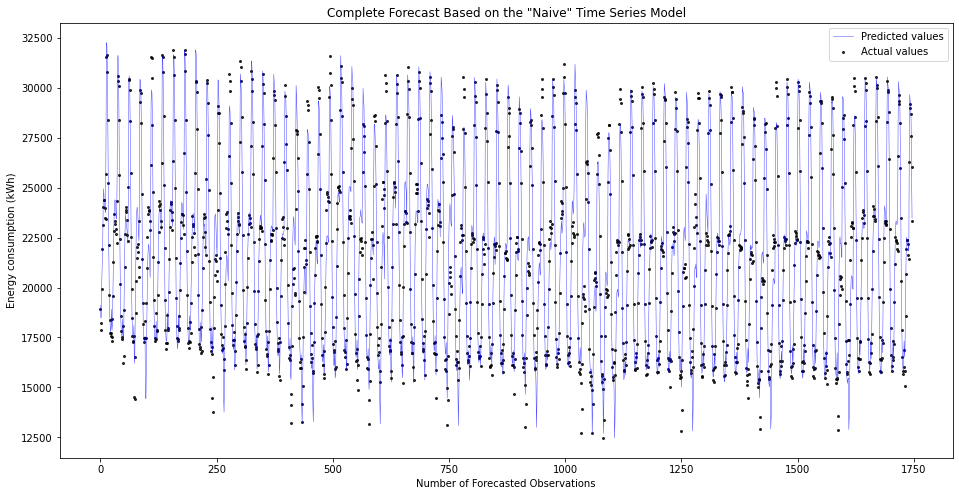

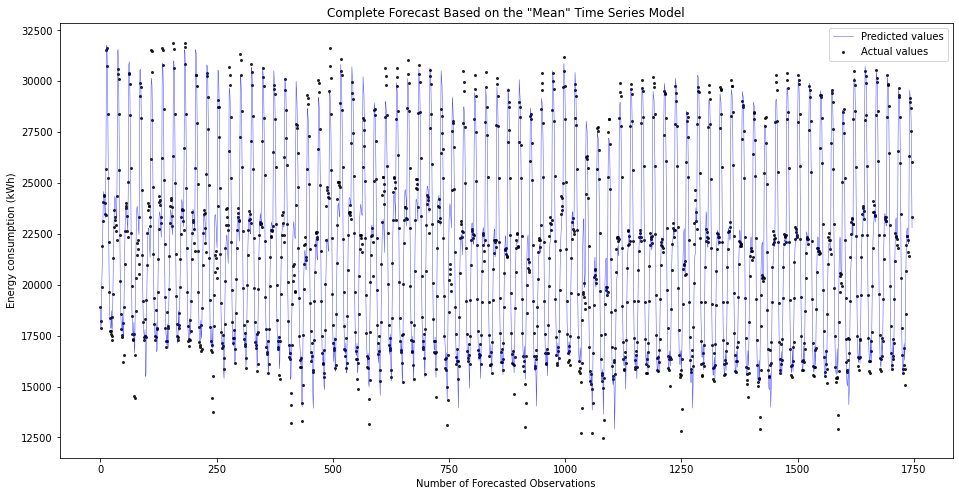

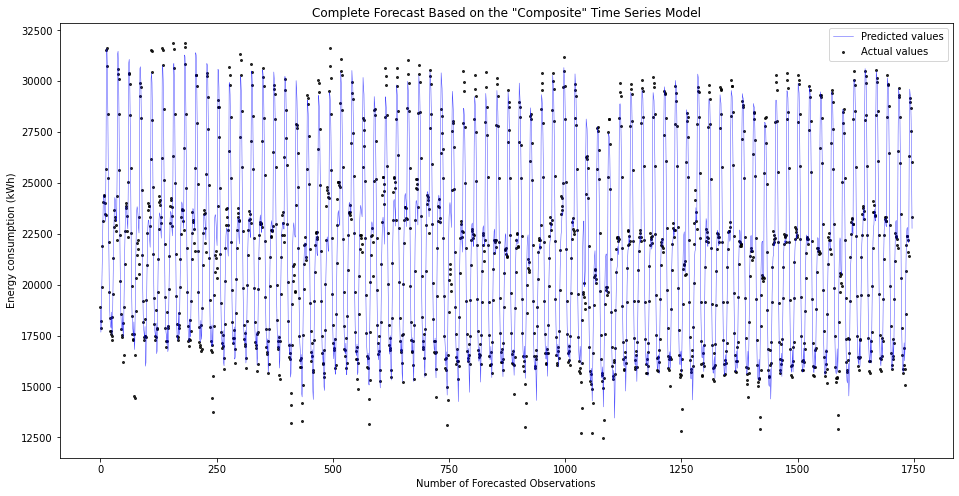

In [ ]:
y = power_hour.loc[:, ["MeanConsumption"]].values.reshape(-1)
u = power_hour.loc[:, ["Zone1"]].values.reshape(-1)
v = power_hour.loc[:, ["Zone2"]].values.reshape(-1)
w = power_hour.loc[:, ["Zone3"]].values.reshape(-1)
n_oos = 1747

show_fit_report(fc_Naive[-n_oos:], y[-n_oos:], 'Complete Forecast Based on the "Naive" Time Series Model')
show_fit_report(fc_Mean[-n_oos:], y[-n_oos:], 'Complete Forecast Based on the "Mean" Time Series Model')
#show_fit_report(fc_Zone1[-n_oos:], u[-n_oos:], 'Forecast for Zone 1 Based on the "Mean" Time Series Model')
#show_fit_report(fc_Zone2[-n_oos:], v[-n_oos:], 'Forecast for Zone 2 Based on the "Mean" Time Series Model')
#show_fit_report(fc_Zone3[-n_oos:], w[-n_oos:], 'Forecast for Zone 3 Based on the "Mean" Time Series Model') #combing these three forecasts yields the composite forecast
show_fit_report(fc_Comp[-n_oos:], y[-n_oos:], 'Complete Forecast Based on the "Composite" Time Series Model')

**Plotting Forecasts for the Last Week of Observations Only**

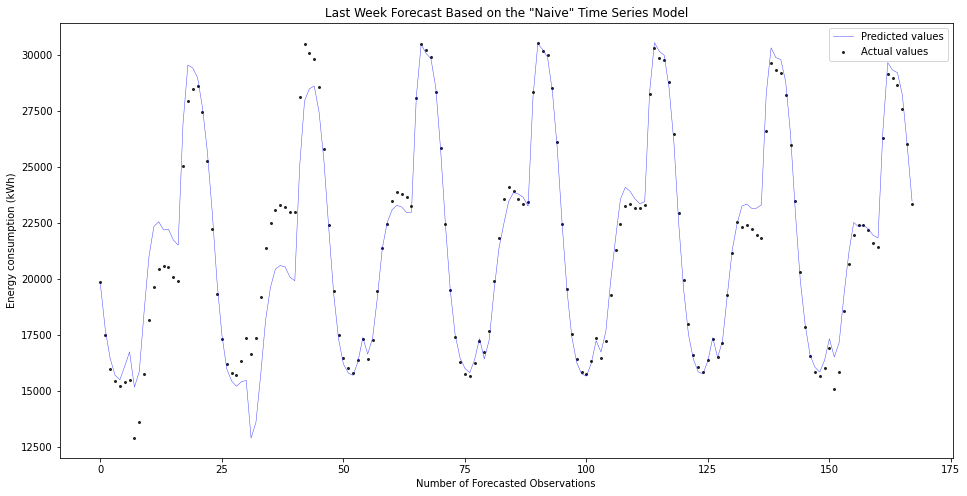

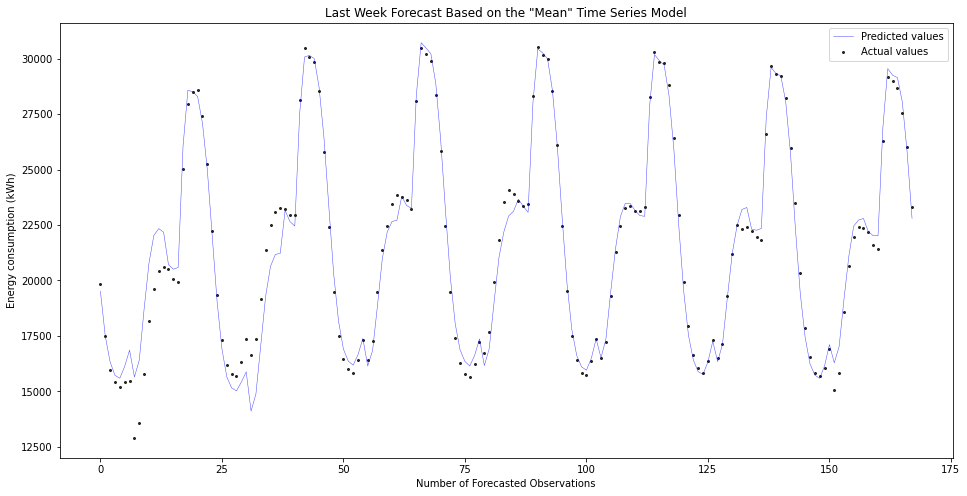

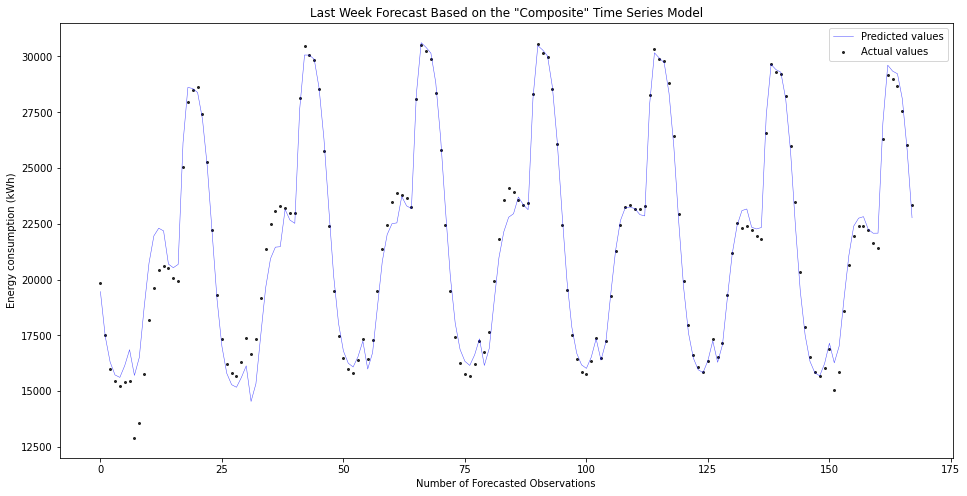

In [ ]:
y = power_hour.loc[:, ["MeanConsumption"]].values.reshape(-1)
u = power_hour.loc[:, ["Zone1"]].values.reshape(-1)
v = power_hour.loc[:, ["Zone2"]].values.reshape(-1)
w = power_hour.loc[:, ["Zone3"]].values.reshape(-1)
n_oos = 1747

show_fit_report(fc_Naive[-7*24:], y[-7*24:], 'Last Week Forecast Based on the "Naive" Time Series Model')
show_fit_report(fc_Mean[-7*24:], y[-7*24:], 'Last Week Forecast Based on the "Mean" Time Series Model')
#show_fit_report(fc_Zone1[-7*24:], u[-7*24:], 'Last Week Forecast for Zone 1 Based on the "Mean" Time Series Model')
#show_fit_report(fc_Zone2[-7*24:], v[-7*24:], 'Last Week Forecast for Zone 2 Based on the "Mean" Time Series Model')
#show_fit_report(fc_Zone3[-7*24:], w[-7*24:], 'Last Week Forecast for Zone 3 Based on the "Mean" Time Series Model') #combing these three forecasts yields the composite forecast
show_fit_report(fc_Comp[-7*24:], y[-7*24:], 'Last Week Forecast Based on the "Composite" Time Series Model')

# Support Vector Machine (SVM)

**Running the default svr on differentiated means against the covariates and the lagged differences**

In [ ]:
from sklearn.svm import SVR

#Running the default SVR model and testing its predictions on the validation set
svr = SVR()
svr.fit(X_train, y_train)
pred_svr = svr.predict(X_valid)

In [ ]:
#Error measures of the predictions of the default SVR model on the validation set
print('R2: %.2f' % r2_score(y_valid, pred_svr))
print("MSE: %.2f" % mean_squared_error(y_valid, pred_svr))
print("MAE: %.2f" % mean_absolute_error(y_valid, pred_svr))
print("RMSE:%.2f" %mean_squared_error(y_valid, pred_svr, squared=False))

R2: 0.33
MSE: 3011628.14
MAE: 1160.60
RMSE:1735.40


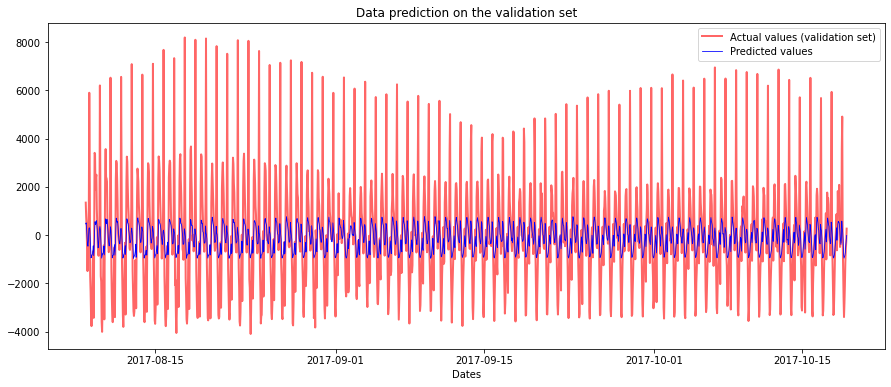

In [ ]:
#Plotting actual target values in the validation set and the predicted ones by the default svr.
train_timestamps = X_valid.index

plt.figure(figsize=(15,6))
plt.plot(train_timestamps, y_valid, color = 'red', linewidth=2.0, alpha=0.6)
plt.plot(train_timestamps, pred_svr, color = 'blue', linewidth=0.8)
plt.legend(['Actual values (validation set)','Predicted values'])
plt.xlabel('Dates')
plt.title("Data prediction on the validation set")
plt.show()

**Using gridsearch to find the best parameters of our SVR model.**


In [ ]:
param_search = {'C':[1,10,100,1000],
        'gamma':[1,0.1,0.001,0.0001]}
tscv = TimeSeriesSplit(n_splits=5)
svr_cv = GridSearchCV(estimator=svr, cv=tscv,
                        param_grid=param_search)
svr_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001]})

In [ ]:
print(svr_cv.best_score_)
print(svr_cv.best_params_)

0.03837115080143081
{'C': 1000, 'gamma': 0.0001}


In [ ]:
pred_optimal_svr = svr_cv.predict(X_test)

In [ ]:
print('R2: %.2f' % r2_score(y_test, pred_optimal_svr))
print("MSE: %.2f" % mean_squared_error(y_test, pred_optimal_svr))
print("MAE: %.2f" % mean_absolute_error(y_test, pred_optimal_svr))
print("RMSE:%.2f" %mean_squared_error(y_test, pred_optimal_svr, squared=False))

R2: 0.09
MSE: 3059843.46
MAE: 1246.14
RMSE:1749.24


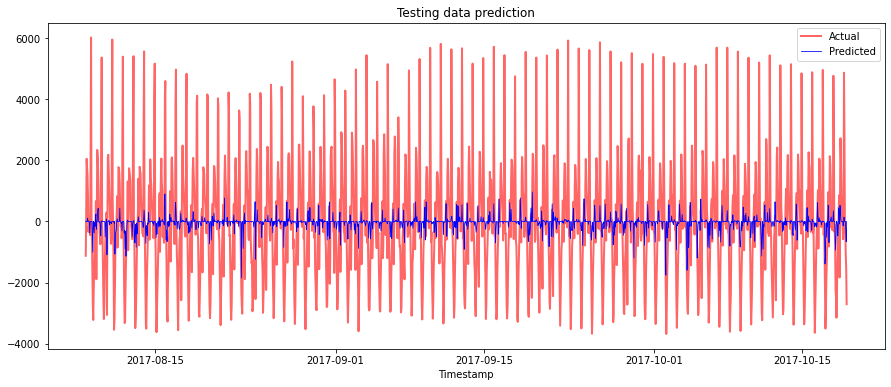

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, pred_optimal_svr, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Testing data prediction")
plt.show()

# Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor()

In [ ]:
etr.fit(X_train, y_train)
pred_etr = etr.predict(X_valid)

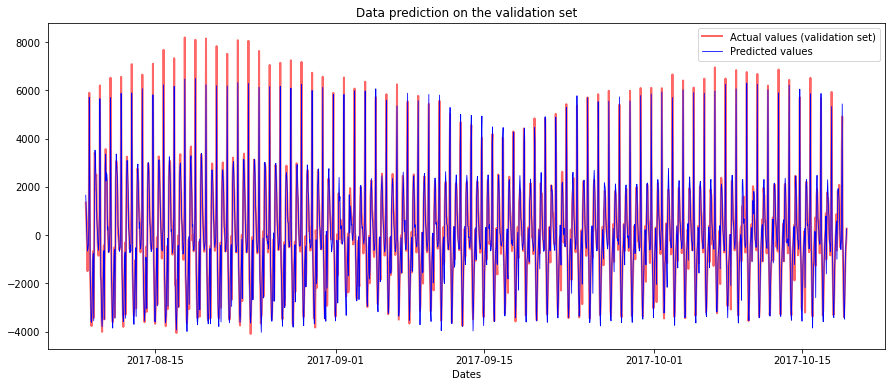

In [ ]:
#Plotting actual target values in the validation set and the predicted ones by the default ExtraTrees Regressor
plt.figure(figsize=(15,6))
plt.plot(train_timestamps, y_valid, color = 'red', linewidth=2.0, alpha=0.6)
plt.plot(train_timestamps, pred_etr, color = 'blue', linewidth=0.8)
plt.legend(['Actual values (validation set)','Predicted values'])
plt.xlabel('Dates')
plt.title("Data prediction on the validation set")
plt.show()

In [ ]:
print('R2: %.2f' % r2_score(y_valid, pred_etr))
print("MSE: %.2f" % mean_squared_error(y_valid, pred_etr))
print("MAE: %.2f" % mean_absolute_error(y_valid, pred_etr))
print("RMSE:%.2f" %mean_squared_error(y_valid, pred_etr, squared=False))

R2: 0.96
MSE: 163901.75
MAE: 279.95
RMSE:404.85


In [ ]:
param_search = {'n_estimators': range(20,101,10),
        'max_depth':range(3,12,2), 
        'min_samples_split':range(20,101,20)}
tscv = TimeSeriesSplit(n_splits=5)
etr_cv = GridSearchCV(estimator=etr, cv=tscv,
                        param_grid=param_search)
etr_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ExtraTreesRegressor(),
             param_grid={'max_depth': range(3, 12, 2),
                         'min_samples_split': range(20, 101, 20),
                         'n_estimators': range(20, 101, 10)})

In [ ]:
print(etr_cv.best_score_)
print(etr_cv.best_params_)

0.9564684904463425
{'max_depth': 11, 'min_samples_split': 60, 'n_estimators': 20}


In [ ]:
pred_optimal_etr = etr_cv.predict(X_test)

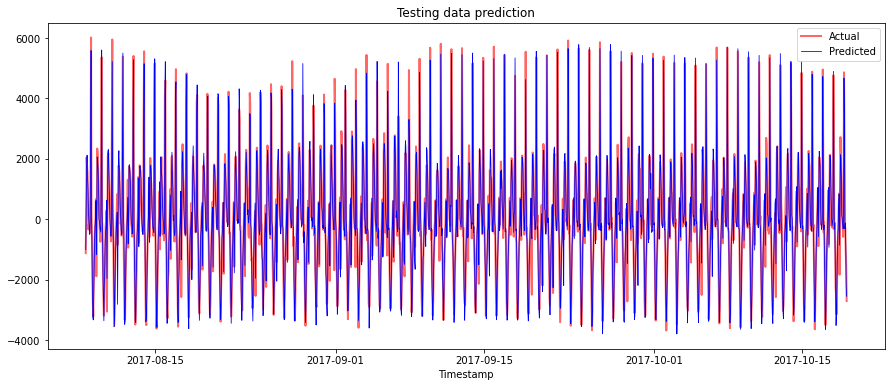

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, pred_optimal_etr, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Testing data prediction")
plt.show()

In [ ]:
print('R2: %.2f' % r2_score(y_test, pred_optimal_etr))
print("MSE: %.2f" % mean_squared_error(y_test, pred_optimal_etr))
print("MAE: %.2f" % mean_absolute_error(y_test, pred_optimal_etr))
print("RMSE:%.2f" %mean_squared_error(y_test, pred_optimal_etr, squared=False))

R2: 0.97
MSE: 115990.42
MAE: 241.32
RMSE:340.57


#GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

In [ ]:
gbr.fit(X_train, y_train)
pred_gbr = gbr.predict(X_valid)

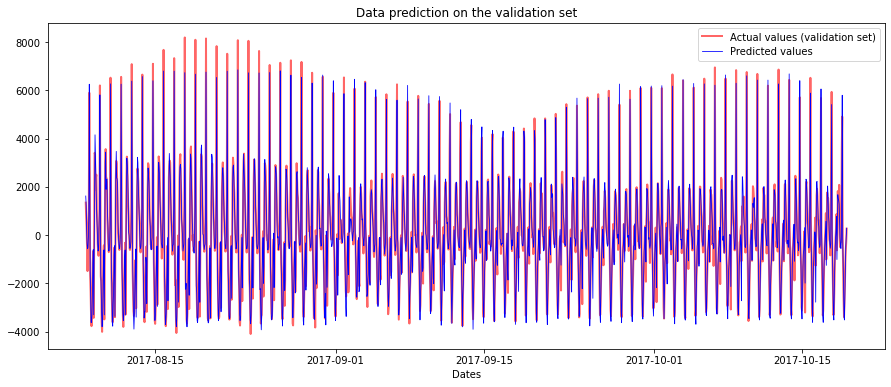

In [ ]:
#Plotting actual target values in the validation set and the predicted ones by the default GradientBoosting Regressor
plt.figure(figsize=(15,6))
plt.plot(train_timestamps, y_valid, color = 'red', linewidth=2.0, alpha=0.6)
plt.plot(train_timestamps, pred_gbr, color = 'blue', linewidth=0.8)
plt.legend(['Actual values (validation set)','Predicted values'])
plt.xlabel('Dates')
plt.title("Data prediction on the validation set")
plt.show()

In [ ]:
print('R2: %.2f' % r2_score(y_valid, pred_gbr))
print("MSE: %.2f" % mean_squared_error(y_valid, pred_gbr))
print("MAE: %.2f" % mean_absolute_error(y_valid, pred_gbr))
print("RMSE:%.2f" %mean_squared_error(y_valid, pred_gbr, squared=False))

R2: 0.97
MSE: 142053.37
MAE: 266.47
RMSE:376.90


In [ ]:
param_search = {'n_estimators': range(20,101,10),
        'max_depth':range(3,12,2), 
        'min_samples_split':range(20,101,20)}
tscv = TimeSeriesSplit(n_splits=5)
gbr_cv = GridSearchCV(estimator=gbr, cv=tscv,
                        param_grid=param_search)
gbr_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': range(3, 12, 2),
                         'min_samples_split': range(20, 101, 20),
                         'n_estimators': range(20, 101, 10)})

In [ ]:
print(gbr_cv.best_score_)
print(gbr_cv.best_params_)

0.957732317033974
{'max_depth': 3, 'min_samples_split': 80, 'n_estimators': 60}


In [ ]:
pred_optimal_gbr = gbr_cv.predict(X_test)

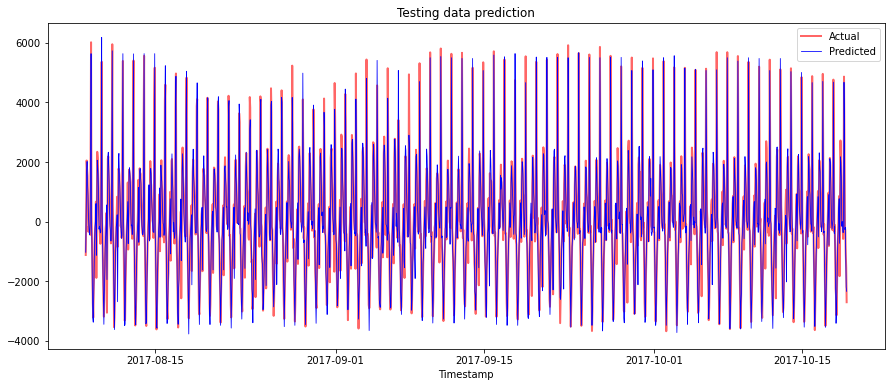

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, pred_optimal_gbr, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Testing data prediction")
plt.show()

In [ ]:
print('R2: %.2f' % r2_score(y_test, pred_optimal_gbr))
print("MSE: %.2f" % mean_squared_error(y_test, pred_optimal_gbr))
print("MAE: %.2f" % mean_absolute_error(y_test, pred_optimal_gbr))
print("RMSE:%.2f" %mean_squared_error(y_test, pred_optimal_gbr, squared=False))

R2: 0.96
MSE: 121420.78
MAE: 245.48
RMSE:348.45


#Autogluon

In [ ]:
!pip install autogluon

  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uninstalled urllib3-1.26.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import autogluon
from autogluon.tabular import TabularPredictor

In [ ]:
X_train_auto = pd.DataFrame(data=X_train, columns=X_train.columns)
X_train_auto = X_train_auto.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
train_data = pd.concat([X_train_auto, y_train], axis=1)

In [ ]:
X_test_auto = pd.DataFrame(data=X_test, columns=X_test.columns)
X_test_auto = X_test_auto.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
test_data = pd.concat([X_test_auto, y_test], axis=1)

In [ ]:
# Train the Autogluon model and it will adjust parameters automatically
pred_autogluon = TabularPredictor(label="diff_mean_1", eval_metric="mean_squared_error").fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20220504_161635/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220504_161635/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    5217
Train Data Columns: 12
Label Column: diff_mean_1
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (7483.86450777778, -5269.650291111113, 1.81295, 2184.33569)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10985.99 MB
	Train Data (Original)  Memory Usage: 0.5 MB (0.0% of ava

[1000]	valid_set's l2: 105188


	-104487.073	 = Validation score   (mean_squared_error)
	2.75s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 118521


	-117312.9608	 = Validation score   (mean_squared_error)
	1.7s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-141115.8786	 = Validation score   (mean_squared_error)
	12.09s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: CatBoost ...
	-108474.0253	 = Validation score   (mean_squared_error)
	51.49s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-127061.3684	 = Validation score   (mean_squared_error)
	2.73s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-128402.7648	 = Validation score   (mean_squared_error)
	5.61s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-121575.4134	 = Validation score   (mean_squared_error)
	6.52s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-128315.0163	 = Validation score   (mean_squared_error)
	29.07s	 = Training   runtime
	0.01s	 = Validation runtime
Fit

In [ ]:
# Print the leaderboard of different algorithms
# The evaluation metric is "MSE" as score_test
pred_autogluon.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE,-111950.181987,-127061.368388,0.403667,0.103197,2.728329,0.403667,0.103197,2.728329,1,True,7
1,LightGBM,-113193.637487,-117312.960838,0.119960,0.031054,1.703986,0.119960,0.031054,1.703986,1,True,4
2,CatBoost,-113479.327243,-108474.025309,0.019416,0.004977,51.493210,0.019416,0.004977,51.493210,1,True,6
3,XGBoost,-126498.349922,-121575.413384,0.049354,0.021565,6.520546,0.049354,0.021565,6.520546,1,True,9
4,RandomForestMSE,-129292.411419,-141115.878550,0.331547,0.205094,12.085509,0.331547,0.205094,12.085509,1,True,5
5,WeightedEnsemble_L2,-136801.510923,-100476.265176,0.393211,0.086991,59.109358,0.021635,0.000508,0.288460,2,True,12
6,LightGBMLarge,-163653.732583,-114104.951956,0.202255,0.045361,4.573642,0.202255,0.045361,4.573642,1,True,11
7,LightGBMXT,-170106.708436,-104487.073000,0.149905,0.036145,2.754045,0.149905,0.036145,2.754045,1,True,3
8,KNeighborsUnif,-177527.352554,-177335.883850,0.104270,0.103932,0.026201,0.104270,0.103932,0.026201,1,True,1
9,KNeighborsDist,-178539.433313,-174844.550167,0.127143,0.106354,0.029530,0.127143,0.106354,0.029530,1,True,2
